In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
import pandas as pd
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march 13th 2014 the booklet had been dow...,0
3,click below for a free download of a colorfull...,1
4,click on the download 7 42 mb green banner link,0


In [5]:
df.shape #BUG: ADD SOMEHOW 2 MORE LINES

(45600, 2)

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(45599, 2)

In [8]:
# df.label = df.label.astype(int)

In [9]:
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march 13th 2014 the booklet had been dow...,0
3,click below for a free download of a colorfull...,1
4,click on the download 7 42 mb green banner link,0


In [10]:
!pip install transformers

     |████████████████████████████████| 890kB 4.5MB/s 
     |████████████████████████████████| 3.0MB 23.5MB/s 
     |████████████████████████████████| 1.1MB 54.3MB/s 
     |████████████████████████████████| 890kB 54.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cfbe537fadfd9b9e1a6feb622297899df20ca693ce507a71b4849265e5cf99dd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# can be up to 512 for BERT
max_length = 50 #128
batch_size = 6

In [14]:
from sklearn.model_selection import train_test_split
cyber_df_train, cyber_df_test = train_test_split(df, test_size=0.2)

In [15]:
import tensorflow as tf
import numpy as np

def cyber_gen(df):
    def g():
        for row in df.itertuples():
            text = row.post
            # max length of the text that can go to BERT, add [PAD] tokens, add [CLS], [SEP], add attention mask to not focus on pad tokens
            tokenized = tokenizer(text, max_length=max_length, padding='max_length', truncation=True )
            # print(tokenized)
            yield {k: np.array(tokenized[k]) for k in tokenized}, row.label
    return g

input_names = ['input_ids', 'token_type_ids', 'attention_mask']
data_types = ({k: tf.int32 for k in input_names}, tf.int64)
data_shapes = ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([]))

cyber_data_train = tf.data.Dataset.from_generator(cyber_gen(cyber_df_train),data_types, data_shapes).shuffle(100).batch(32).repeat(4)

cyber_data_test = tf.data.Dataset.from_generator(cyber_gen(cyber_df_test),data_types, data_shapes).shuffle(100).batch(32).repeat(4)

In [16]:
cyber_data_train

<RepeatDataset shapes: ({input_ids: (None, None), token_type_ids: (None, None), attention_mask: (None, None)}, (None,)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [17]:
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

es=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min',restore_best_weights=True)
callbacks_list = [es, checkpoint]

opt=keras.optimizers.Adam(lr=0.00003)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [18]:
history = model.fit(
    cyber_data_train,
    epochs=100, steps_per_epoch=64, 
    validation_steps=16,
    validation_data=cyber_data_test, callbacks=[callbacks_list]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.7993
Epoch 00001: val_accuracy improved from -inf to 0.89453, saving model to model.h5
64/64 [==============================] - 27s 428ms/step - loss: 0.4231 - accuracy: 0.7993 - val_loss: 0.2624 - val_accuracy: 0.8945
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.8921
Epoch 00002: val_accuracy improved from 0.89453 to 0.89648, saving model to model.h5
64/64 [==============================] - 25s 396ms/step - loss: 0.2692 - accuracy: 0.8921 - val_loss: 0.2600 - val_accuracy: 0.8965
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.8848
Epoch 00003: val_accuracy improved from 0.89648 to 0.90039, saving model to model.h5
64/64 [==============================] - 26s 407ms/step - loss: 0.2703 - accuracy: 0.8848 - val_loss: 0.2432 - val_accuracy: 0.9004
Epoch 4/100
64/64 [==============================] - ETA: 0s - loss

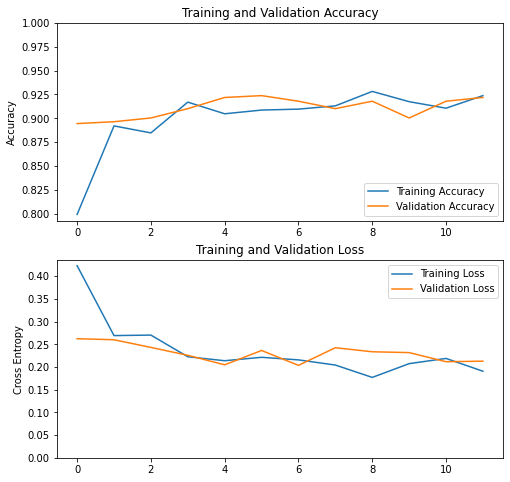

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.load_weights('model.h5')

In [21]:
from scipy.special import softmax
new_tweet = "I hate black people, they are stupid and look like shit"
tokenized = tokenizer(new_tweet)
logits = model.predict({k: np.array(tokenized[k])[None] for k in input_names})[0]
# print(logits)
scores = softmax(logits, axis=1)[:,1]
print(1-scores[0], 'probability that input text is non-cyberbulling')
print(scores[0], 'probability that input text is cyberbulling')

0.36050552129745483 probability that input text is non-cyberbulling
0.6394945 probability that input text is cyberbulling
